# Image Captioning Project

### Importing library

In [9]:
import tensorflow as tf
import os 
import pandas as pd
from PIL import Image

In [2]:
IMG_PATH = "./Flickr8k_Dataset/Flicker8k_Dataset/"
caption_folder = "caption/captions.txt"

In [29]:
def load_descriptions(text):
    mapping = dict()
    text = text.split('\n')
    text = text[1:]
    for line in text:
        token = line.split(',')
        if len(line)<2:
            continue
        img_ids = token[0].split(".")[0]
        img_desc = token[1]
        if img_ids not in mapping:
            mapping[img_ids] = []
        mapping[img_ids].append(img_desc)
    return mapping

In [30]:
def read_text_file(fname):
    with open(fname, 'r') as f:
        read = f.read()
    return read

In [31]:
with open('caption/captions.txt', 'r') as f:
    descriptions = load_descriptions(f.read())

In [71]:
img = Image.open('./Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')

## Data Cleaning

In [32]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import pickle
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, LSTM
from tensorflow.keras.models import Model, load_model

In [33]:
'''
project about - generating english text
we cannot remove stopwords
do not perform stem words
because we want grammeticaly correct

lower case,remove number,punctuation,numbers will help in reducing vocab size
'''

'\nproject about - generating english text\nwe cannot remove stopwords\ndo not perform stem words\nbecause we want grammeticaly correct\n\nlower case,remove number,punctuation,numbers will help in reducing vocab size\n'

In [34]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+', ' ', sentence)
    
    return sentence

In [35]:
print(clean_text("Umang is a # 1 boy"))

umang is a boy


In [36]:
# clean all captions
for key, caption in descriptions.items():
    for i in range(len(caption)):
        caption[i] = clean_text(caption[i])


In [77]:
# write data to a text file
with open("descriptions.text", "w") as f:
    json.dump(descriptions, f)


In [37]:
# vocabulary
with open("descriptions.text", 'r') as f:
    descriptions = json.load(f)


In [38]:
# vocab
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [39]:
total_words = []
for key in descriptions.keys():
    [total_words.append(word) for de in descriptions[key] for word in de.split()]

In [40]:
len(total_words)

419830

In [41]:
# filters words from the vocab according to certain threshold frequency

import collections

counter = collections.Counter(total_words)
freq_count = dict(counter)
# print(freq_count)
print(len(freq_count.keys()))


8273


In [42]:
# sort dictionary according to freq count
sorted_freq_cnt = sorted(freq_count.items(), reverse= True, key = lambda x:x[1])
print(type(sorted_freq_cnt))
# filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

<class 'list'>


In [43]:
len(total_words)

1805

## Train/test

In [39]:

def write_to_file(text, name):
    with open(name, 'w') as f:
        for t in text:
            f.write(t)
            f.write('\n')

In [40]:
## Generating test, dev, train data
ids = list(descriptions.keys())
train = write_to_file(ids[:6000], 'train.txt')
dev = write_to_file(ids[6000:7000], 'dev.txt')
test = write_to_file(ids[7000:],'test.txt')

In [44]:
# Loading Training, testing
train_file_data = read_text_file('train.txt')
test_file_data = read_text_file('test.txt')

In [45]:
train = [row for row in train_file_data.split("\n")[:-1]]
test = [row for row in test_file_data.split("\n")[:-1]]

In [46]:
# Prepare descriptions for the training data
# We will add <START> and <EOS> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "<start> " + cap + " <eos>"
        train_descriptions[img_id].append(cap_to_append)

In [47]:
train_descriptions['1000268201_693b08cb0e']

['<start> a child in a pink dress is climbing up a set of stairs in an entry way  <eos>',
 '<start> a girl going into a wooden building  <eos>',
 '<start> a little girl climbing into a wooden playhouse  <eos>',
 '<start> a little girl climbing the stairs to her playhouse  <eos>',
 '<start> a little girl in a pink dress going into a wooden cabin  <eos>']

# Transfer Learning
    Images --> Features
    Text --> Features

## Step -1 Image Feature Extraction 

In [15]:
model = ResNet50(weights = "imagenet", input_shape = (224, 224, 3))


In [42]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
model_new = Model(model.input, model.layers[-2].output)

In [7]:
def preprocess_img(img):
    img = image.load_img(img, target_size=(224,224,3))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    
    # Normalisation
    img = preprocess_input(img)
    return img

In [82]:
img = preprocess_img(IMG_PATH +"1000268201_693b08cb0e" + ".jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


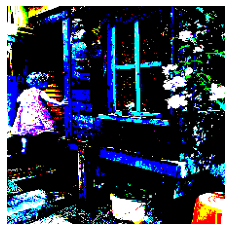

In [88]:
plt.imshow(img[0])
plt.axis(False)
plt.show()

In [5]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))

    return feature_vector

In [96]:
encode_image(IMG_PATH +"1000268201_693b08cb0e" + ".jpg")

array([0.06535921, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [100]:
start = time.time()
encoding_train = {}
    #image_id --> feature_vector extracted from Resnet Image

for ix, img_id in enumerate(train):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100 == 0:
        print("Encoding in Progress Time Step :",ix)


end_t = time.time()

Encoding in Progress Time Step : 0
Encoding in Progress Time Step : 100
Encoding in Progress Time Step : 200
Encoding in Progress Time Step : 300
Encoding in Progress Time Step : 400
Encoding in Progress Time Step : 500
Encoding in Progress Time Step : 600
Encoding in Progress Time Step : 700
Encoding in Progress Time Step : 800
Encoding in Progress Time Step : 900
Encoding in Progress Time Step : 1000
Encoding in Progress Time Step : 1100
Encoding in Progress Time Step : 1200
Encoding in Progress Time Step : 1300
Encoding in Progress Time Step : 1400
Encoding in Progress Time Step : 1500
Encoding in Progress Time Step : 1600
Encoding in Progress Time Step : 1700
Encoding in Progress Time Step : 1800
Encoding in Progress Time Step : 1900
Encoding in Progress Time Step : 2000
Encoding in Progress Time Step : 2100
Encoding in Progress Time Step : 2200
Encoding in Progress Time Step : 2300
Encoding in Progress Time Step : 2400
Encoding in Progress Time Step : 2500
Encoding in Progress Tim

In [102]:
print("time taken by training, ",end_t-start)

time taken by training,  1528.7839727401733


In [103]:
# Store everything to the disk //
with open("encoded_train_features.pk1","wb") as f:
    pickle.dump(encoding_train, f)

In [91]:
start = time.time()
encoding_test = {}
    #image_id --> feature_vector extracted from Resnet Image

for ix, img_id in enumerate(test):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100 == 0:
        print("Encoding in Progress Time Step :",ix)


end_t = time.time()
print("time taken",end_t-start)

Encoding in Progress Time Step : 0
Encoding in Progress Time Step : 100
Encoding in Progress Time Step : 200
Encoding in Progress Time Step : 300
Encoding in Progress Time Step : 400
Encoding in Progress Time Step : 500
Encoding in Progress Time Step : 600
Encoding in Progress Time Step : 700
Encoding in Progress Time Step : 800
Encoding in Progress Time Step : 900
Encoding in Progress Time Step : 1000
time taken 291.80375480651855


In [94]:
with open("encoded_test_features.pk1", "wb") as f:
    pickle.dump(encoding_test, f)

### Pre-processing for Captions

In [48]:
#vocab
word_to_idx = {}
idx_to_word = {}
for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
    

In [49]:
# add <start> and <eos> to model
idx_to_word[1806] = "<eos>"
word_to_idx["<eos>"] = 1806

idx_to_word[1807] = "<start>"
word_to_idx["<start>"] = 1807

vocab_size = len(word_to_idx) + 1
print(vocab_size)

1808


In [50]:
max_len = 0
for k in train_descriptions.keys():
    
    for word in train_descriptions[k]:
        max_len = max(max_len, len(word.split()))
        

In [51]:
print(max_len)

35


## Data Loader (Generator)

In [52]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    x1, x2, y = [],[],[]
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                seq = [word_to_idx for word in desc.split() if word in idx]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    y = seq[i]
                    
                    #0 donate padding word
                    xi = pad_sequences([xi], maxlen = max_len, value = 0, paddint = "post")
                    yi = to_categorical([yi], num_classes = vocab_size)[0]
                    
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
                if n == batch_size:
                    yield [[np.array(x1),np.array(x2)],np.array(y)]
                    
                    x1,x2,y = [],[],[]
                    n = 0

## Word Embeddings

In [31]:
f = open("glove.6B.50d.txt", encoding = "utf-8")

In [32]:
embedding_index = {}

n = 100
for line in f:
    values  = line.split()
    word = values[0]
    embedding_word = np.array(values[1:], dtype = "float")
    embedding_index[word] = embedding_word

In [33]:
f.close()

In [34]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [35]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1808, 50)

In [67]:
with open("embedding_matrix.txt", 'w') as f:
    f.write(str(embedding_matrix))

#### Model Architecture

In [58]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation = "relu")(inp_img1)


In [11]:
# Captions as Input
max_len = 35
vocab_size = 1808
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim = vocab_size, output_dim = 50, mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [60]:
from tensorflow.keras.layers import Add
decoder1 = Add()([inp_img2, inp_cap3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

#Combined Model
model = Model(inputs=[input_img_features, input_captions], outputs = outputs)

In [61]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       90400       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [62]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [63]:
model.compile(loss = "categorical_crossentropy",optimizer = "adam")

## Training of Model

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)// 3

In [2]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
        model.fit_generator(generator,epochs=1, steps_per_epoch = steps )
        model.save("./model_weights/'model_'+str(i)+'.h5'")

In [ ]:
train()

In [54]:
## Prediction 
t_model = load_model('./content/model_weights/model_9.h5')
max_len = 35
def predict_captions(photo):
  in_text = "<start>"
  for i in range(max_len):
    sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence = pad_sequences([sequence], maxlen= max_len, padding="post")
    ypred = t_model.predict((photo,sequence))
    ypred = ypred.argmax()
    word = idx_to_word[ypred]
    in_text +=(' '+word)

    if word == "<eos>":
      break
  final_caption = in_text.split()[1:-1]
  final_caption = ' '.join(final_caption)
  return final_caption

1091
a young girl in a red uniform is running on the field


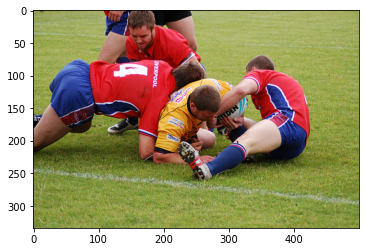

1091
a group of people are standing on a crowd of a crowd


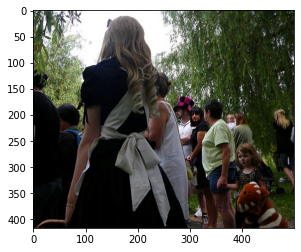

1091
a brown dog is running through the grass


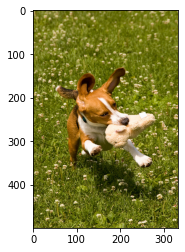

1091
a man is running a dirt


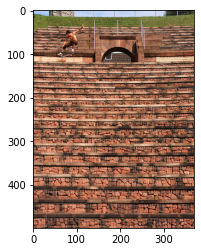

1091
a man in a red shirt is riding on a bike


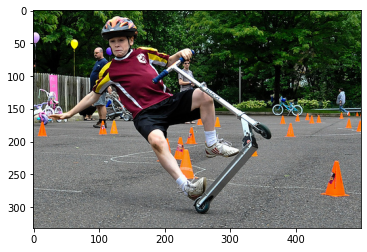

1091
a man in a blue shirt is wearing a blue shirt is wearing a blue shirt


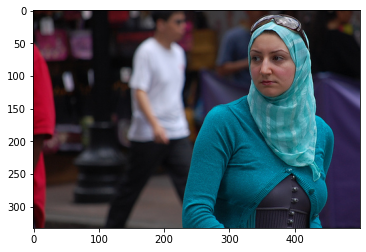

1091
a white dog is jumping in the air


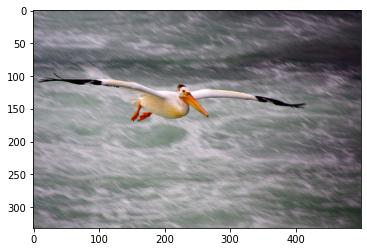

1091
a man in a red shirt is riding a trick on a ramp


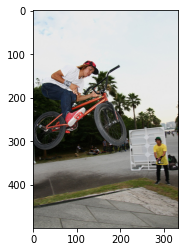

1091
a dog is jumping on a bed


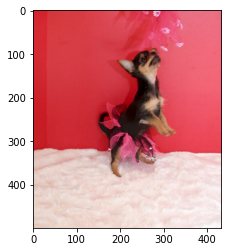

1091
a biker biker a bike on a dirt


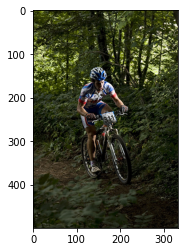

1091
a man in a woman and a man


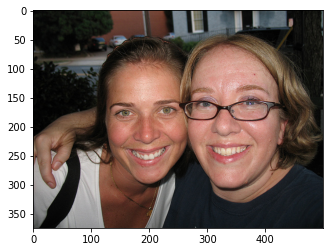

1091
a man in a man and a man in a man


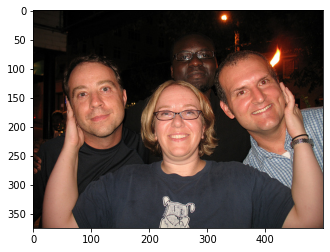

1091
a man in a red shirt is sitting on a building


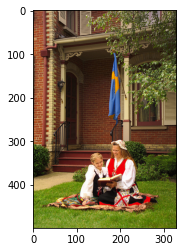

1091
a man is jumping on a ramp


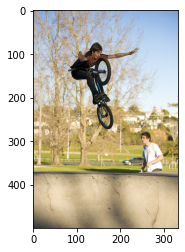

1091
a man in a red jacket is red a red car


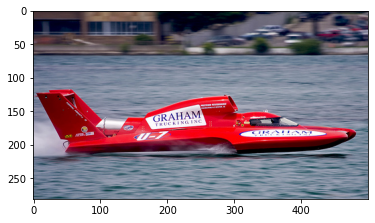

In [62]:
#pick some random Images from results
with open("encoded_test_features.pk1", "rb") as f:
  encoding_test = pickle.load(f)
for i in range(15):
  idx = i
  
  all_img_names = list(encoding_test.keys())
  print(len(all_img_names))
  img_name = all_img_names[idx]
  photo_2048 = encoding_test[img_name].reshape((1,2048))
  
  i = plt.imread(IMG_PATH+img_name+".jpg")
  caption = predict_captions(photo_2048)
  print(caption)
  plt.imshow(i) 

  plt.show()

1091
a young girl in a red uniform is running on the field


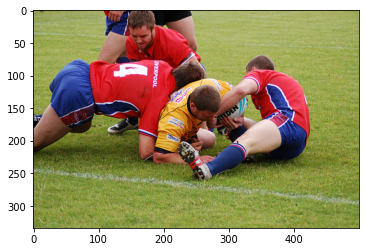

1091
a group of people are standing on a crowd of a crowd


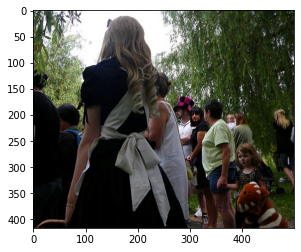

1091
a brown dog is running through the grass


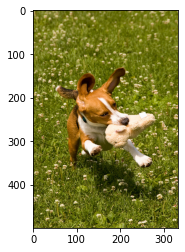

1091
a man is running a dirt


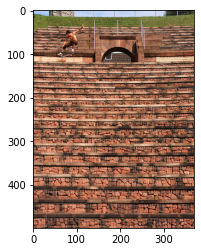

1091
a man in a red shirt is riding a bike on a park


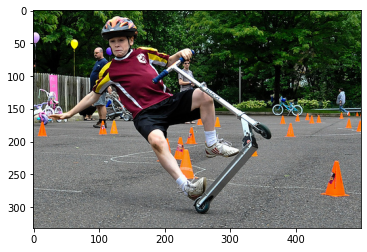

1091
a man in a blue jacket is standing on a street


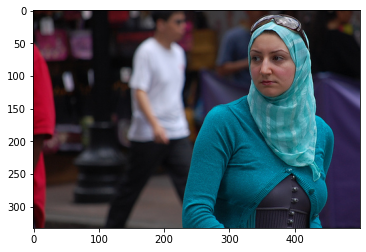

1091
a white dog is jumping in the air


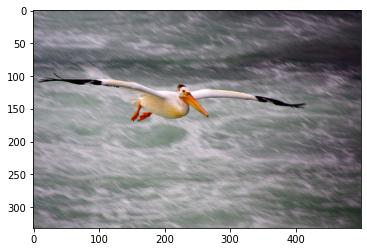

1091
a man in a red shirt is riding a trick on a ramp


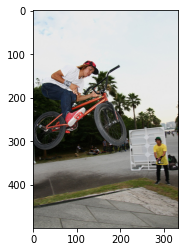

1091
a dog is jumping on a bed


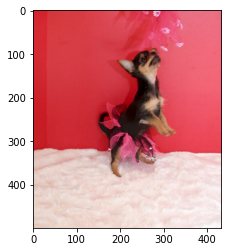

1091
a biker biker a bike on a trail


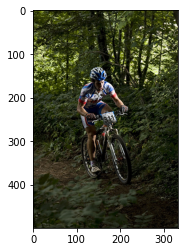

1091
a man in a woman and a man smiling a picture


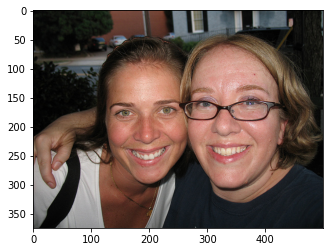

1091
a man in a black shirt and a man in a man


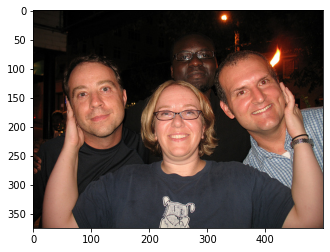

1091
a man in a red shirt is sitting on a building


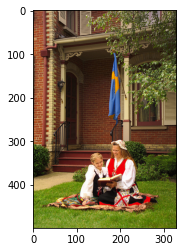

1091
a man jumps a trick on a ramp


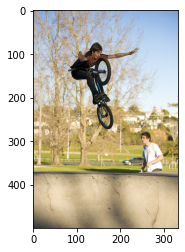

1091
a man in a red jacket is running a red car


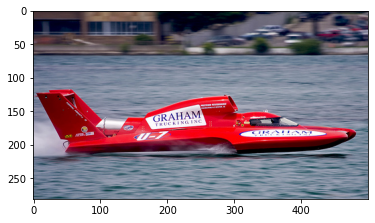

In [64]:
#pick some random Images from results
with open("encoded_test_features.pk1", "rb") as f:
  encoding_test = pickle.load(f)
for i in range(15):
  idx = i
  
  all_img_names = list(encoding_test.keys())
  print(len(all_img_names))
  img_name = all_img_names[idx]
  photo_2048 = encoding_test[img_name].reshape((1,2048))
  
  i = plt.imread(IMG_PATH+img_name+".jpg")
  caption = predict_captions(photo_2048)
  print(caption)
  plt.imshow(i) 

  plt.show()

a skier is riding a red hill


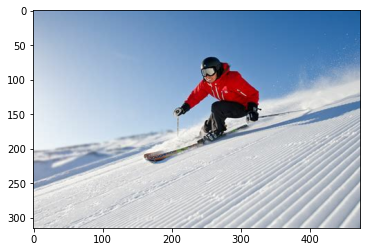

In [55]:
# testing Single image
img_path = "test/ice.jpeg"
encoded_image = encode_image(img_path).reshape((1,2048))
img = plt.imread(img_path)
caption = predict_captions(encoded_image)
plt.imshow(img)
print(caption)